In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn
from scipy.stats import beta

In [2]:
#load data 
data = np.genfromtxt('bandits_data.csv', delimiter=',')
data = data[1:]

In [116]:
#find maximum of the array when exist few elements with maximal value
def find_max(array):
    indices = np.where(array == array.max())[0]
    result = np.random.choice(indices)
    return result

def multiarmed_bandits(data=data, eps=0.01):
    step_size = np.zeros(3)
    quality = np.zeros(3)
    np.random.shuffle(data)
    reward = 0
    mean_revard = []
    for number, sample in enumerate(data):
        if np.random.rand() < eps:
            index = np.random.randint(0, 3)
        else:
            index = find_max(quality)
        #increment step size of the chosen bandit
        step_size[index] += 1
        #compute quality value and mean reward
        quality[index] += 1.0/step_size[index]*(sample[index] - quality[index])
        reward += (sample[index] - reward) / (number+1)
        mean_revard.append(reward)
    return mean_revard, quality.argmax()

#bayesian bandits with prior distribution Beta(1, 1) = Uniform(0, 1) per bandit
def bayesian_bandits(data=data, batch=500):
    np.random.shuffle(data)
    #batch updating
    data = data[:batch]
    beta_parameters = np.ones((3, 2))
    for i in range(3):
        a = np.where(data[:, i] == 1)[0].shape[0]
        b = np.where(data[:, i] == 0)[0].shape[0]
        #posterior - Beta(a + 1, b + 1)
        beta_parameters[i] = beta_parameters[i] + [a, b]
    return beta_parameters

#simulate few runs of the bayesian and sample-averaging agents
def simulate_runs(n_runs, bayes_batch=900):
    #future number of chosen bandits 
    eps_greedy_1 = np.zeros(3)
    eps_greedy_2 = np.zeros(3)
    greedy = np.zeros(3)
    bayesian = np.zeros(3)
    for _ in range(n_runs):
        reward, bandit_1 = multiarmed_bandits(eps=0.1)
        reward, bandit_2 = multiarmed_bandits(eps=0.01)
        reward, bandit_3 = multiarmed_bandits(eps=0.0)
        #params of beta distribution
        params = bayesian_bandits(batch=bayes_batch)
        #generate value from this distributions 
        sample_1 = beta.rvs(params[0][0], params[0][1], size=1)
        sample_2 = beta.rvs(params[1][0], params[1][1], size=1)
        sample_3 = beta.rvs(params[2][0], params[2][1], size=1)
        #find max
        bandit_4 = np.c_[sample_1, sample_2, sample_3].argmax()
        #update number of choices
        eps_greedy_1[bandit_1] += 1
        eps_greedy_2[bandit_2] += 1
        greedy[bandit_3] += 1
        bayesian[bandit_4] += 1
    #update number of choices to the probability of choice
    eps_greedy_1 = eps_greedy_1 / n_runs
    eps_greedy_2 = eps_greedy_2 / n_runs
    greedy = greedy / n_runs
    bayesian = bayesian / n_runs
    return eps_greedy_1, eps_greedy_2, greedy, bayesian

In [128]:
#create 1 run and evaluate the algorithms choice
reward_1, decision_1 = multiarmed_bandits(eps=0.1)
reward_2, decision_2 = multiarmed_bandits(eps=0.01)
reward_3, decision_3 = multiarmed_bandits(eps=0.0)
print('Greedy with eps=0.1 -', decision_1)
print('Greedy with eps=0.01 -', decision_2)
print('Greedy -', decision_3)

Greedy with eps=0.1 - 2
Greedy with eps=0.01 - 1
Greedy - 1


### From the plot below we can conclude about quality of the eps-greedy algorithms: pure greedy algorithm almost always has less reward than eps-greedy algorithms. So, with the large number of test eps-greedy algorithms would converge (find optimal option more quickly) and receive more reward (but sometimes can't converge good).

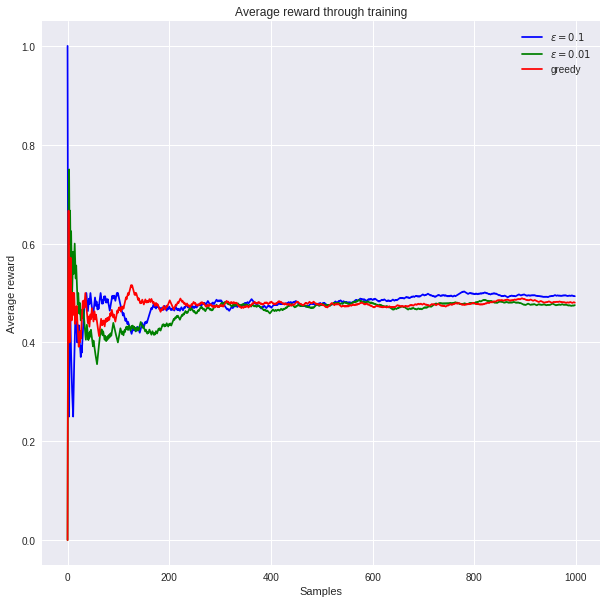

In [129]:
#plot mean rewards
plt.figure(figsize=(10, 10))
plt.plot(reward_1, label='$\epsilon=0.1$', color='b')
plt.plot(reward_2, label='$\epsilon=0.01$', color='g')
plt.plot(reward_3, label='greedy', color='r')
plt.legend()
plt.xlabel('Samples')
plt.ylabel('Average reward')
plt.title('Average reward through training')
plt.show()

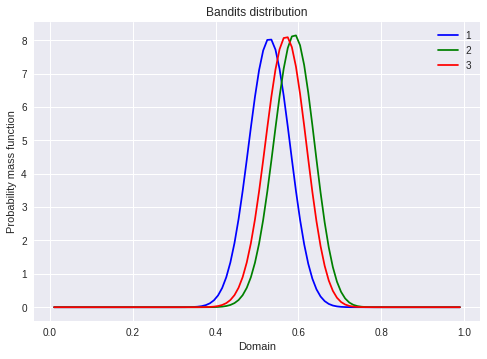

In [130]:
#bayesian posterior distributions
params = bayesian_bandits(batch=100)

x_domain = np.linspace(0.01, 0.99, 100)
plt.plot(x_domain, beta.pdf(x_domain, params[0][0], params[0][1]), label='1', color='b')
plt.plot(x_domain, beta.pdf(x_domain, params[1][0], params[1][1]), label='2', color='g')
plt.plot(x_domain, beta.pdf(x_domain, params[2][0], params[2][1]), label='3', color='r')
plt.legend()
plt.xlabel('Domain')
plt.ylabel('Probability mass function')
plt.title('Bandits distribution')
plt.show()

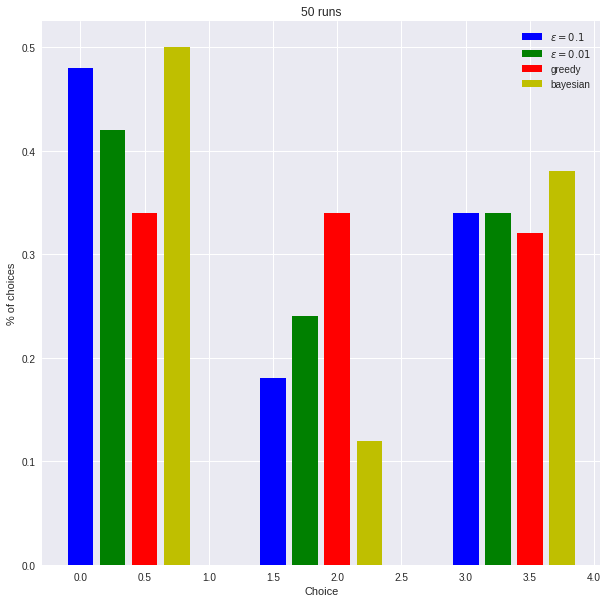

In [140]:
#test on the 50 runs
eps_greedy_1, eps_greedy_2, greedy, bayesian = simulate_runs(50)
bins = np.linspace(0, 3, 3)

plt.figure(figsize=(10, 10))
plt.bar(bins, eps_greedy_1, width=0.2, color='b', label='$\epsilon=0.1$')
plt.bar(bins+0.25, eps_greedy_2, width=0.2, color='g', label='$\epsilon=0.01$')
plt.bar(bins+0.5, greedy, width=0.2, color='r', label='greedy')
plt.bar(bins+0.75, bayesian, width=0.2, color='y', label='bayesian')
plt.legend()
plt.xlabel('Choice')
plt.ylabel('% of choices')
plt.title('50 runs')
plt.show()

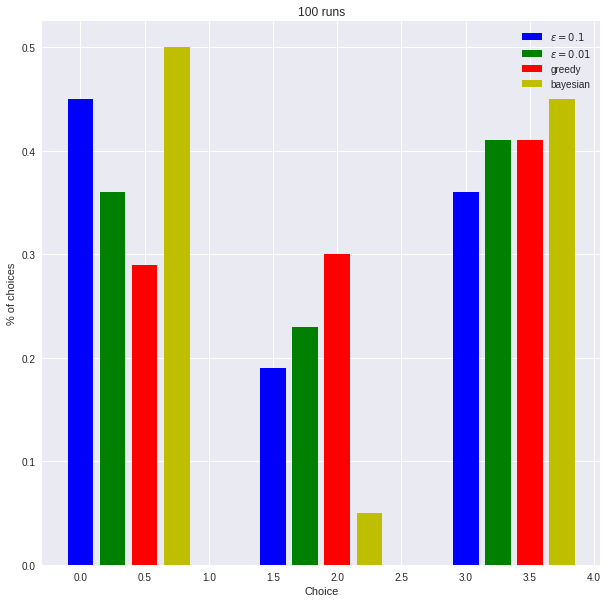

In [141]:
#test on the 100 runs
eps_greedy_1, eps_greedy_2, greedy, bayesian = simulate_runs(100)
bins = np.linspace(0, 3, 3)

plt.figure(figsize=(10, 10))
plt.bar(bins, eps_greedy_1, width=0.2, color='b', label='$\epsilon=0.1$')
plt.bar(bins+0.25, eps_greedy_2, width=0.2, color='g', label='$\epsilon=0.01$')
plt.bar(bins+0.5, greedy, width=0.2, color='r', label='greedy')
plt.bar(bins+0.75, bayesian, width=0.2, color='y', label='bayesian')
plt.legend()
plt.xlabel('Choice')
plt.ylabel('% of choices')
plt.title('100 runs')
plt.show()

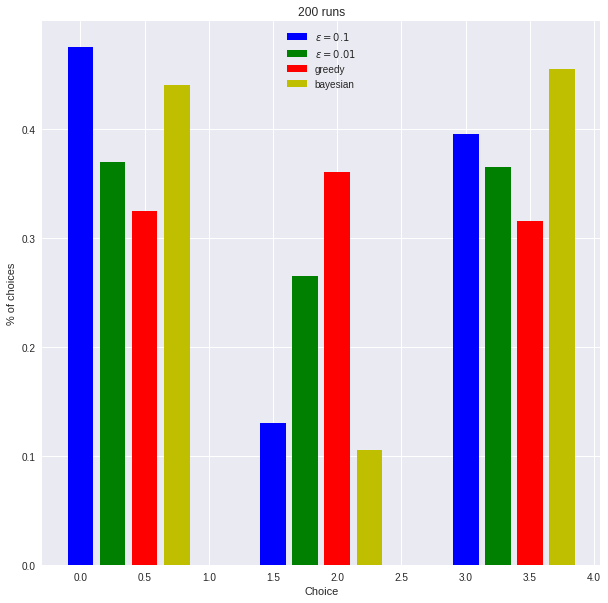

In [142]:
#test on the 200 runs
eps_greedy_1, eps_greedy_2, greedy, bayesian = simulate_runs(200)
bins = np.linspace(0, 3, 3)

plt.figure(figsize=(10, 10))
plt.bar(bins, eps_greedy_1, width=0.2, color='b', label='$\epsilon=0.1$')
plt.bar(bins+0.25, eps_greedy_2, width=0.2, color='g', label='$\epsilon=0.01$')
plt.bar(bins+0.5, greedy, width=0.2, color='r', label='greedy')
plt.bar(bins+0.75, bayesian, width=0.2, color='y', label='bayesian')
plt.legend()
plt.xlabel('Choice')
plt.ylabel('% of choices')
plt.title('200 runs')
plt.show()

## So, the fastest algorithms - greedy with eps=0.1 and greedy with eps=0.01. Pure greedy is less qualitative, and bayesian also good. We can see eps-greedy finds that options 1 and 3 better than 2, but case 1 and case 3 almost equal.